# 06 — Pré-processamento e Modelagem (JupyterLab)

Este notebook dá sequência ao projeto, preparando *features* e treinando modelos de ML.
Ele foi pensado para rodar **localmente** no JupyterLab, com caminhos relativos ao repositório.

> **Dica:** mantenha os dados consolidados em `data/gold/` conforme a estrutura do projeto.


## 0. Configurações iniciais

- Paths
- Dependências
- Parâmetros editáveis (targets, colunas categóricas/numéricas)


In [1]:
# Imports e checagens de ambiente
import os
import sys
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from pathlib import Path
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance


# SHAP é opcional; se não estiver disponível, usamos permutation importance
try:
    import shap
    _HAS_SHAP = True
except Exception:
    _HAS_SHAP = False

PROJECT_ROOT = Path('/home/rusch/Área de trabalho/Projeto_Whirpool/Data_Science_Projects/eda').resolve()
DATA_GOLD = PROJECT_ROOT / 'data' / 'gold'
MODEL_INPUT = PROJECT_ROOT / 'data' / 'model_input'
MODELS_DIR = PROJECT_ROOT / 'models'
REPORTS_DIR = PROJECT_ROOT / 'reports'

for p in [MODEL_INPUT, MODELS_DIR, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print('Project root:', PROJECT_ROOT)
print('Gold path:', DATA_GOLD)
print('Python version:', sys.version.split()[0])

Project root: /home/rusch/Área de trabalho/Projeto_Whirpool/Data_Science_Projects/eda
Gold path: /home/rusch/Área de trabalho/Projeto_Whirpool/Data_Science_Projects/eda/data/gold
Python version: 3.12.7


## 1. Carregamento de dados

Carrega o arquivo consolidado de `data/gold/`.  
> Ajuste o nome do arquivo caso necessário.


In [2]:
# Ajuste aqui o nome do arquivo gold consolidado
# Ex.: 'master_gold.parquet' ou 'gold_consolidado.csv'
GOLD_FILENAME = 'kpi_consolidated_outliers_treated.parquet'  # TODO: ajuste se necessário

gold_path = DATA_GOLD / GOLD_FILENAME
if not gold_path.exists():
    # Fallback: tenta csv com nome similar
    alt = DATA_GOLD / GOLD_FILENAME.replace('.parquet', '.csv')
    if alt.exists():
        gold_path = alt

print('Carregando:', gold_path)

if gold_path.suffix.lower() == '.parquet':
    df = pd.read_parquet(gold_path)
elif gold_path.suffix.lower() == '.csv':
    df = pd.read_csv(gold_path)
else:
    raise FileNotFoundError(f'Arquivo não encontrado: {gold_path}')

print('shape:', df.shape)
display(df.head(10))

Carregando: /home/rusch/Área de trabalho/Projeto_Whirpool/Data_Science_Projects/eda/data/gold/kpi_consolidated_outliers_treated.parquet
shape: (603, 29)


,date_key,y,m,site_code,cost_per_unit_imp,kwh_per_unit_imp,fx_effect_ratio_imp,cost_per_unit_imp_lag1,cost_per_unit_imp_roll3,kwh_per_unit_imp_lag1,...,kwh_per_unit_imp_z,kwh_per_unit_imp_is_outlier,fx_effect_ratio_imp_mean,fx_effect_ratio_imp_std,fx_effect_ratio_imp_z,fx_effect_ratio_imp_is_outlier,fx_effect_ratio_imp_cap,cost_per_unit_imp_robust,kwh_per_unit_imp_robust,fx_effect_ratio_imp_robust
0,20240101,2024,1,SC01,777.922403,0.526513,-3.708762e-08,NaN,NaN,NaN,...,NaN,False,2.718013e-06,3.896301e-06,-0.707107,False,-3.708762e-08,0.000000,0.000000,-0.591246
1,20240201,2024,2,SC01,777.922403,0.526513,1.029906e-07,777.922403,777.922403,0.526513,...,NaN,False,-1.263414e-06,1.932388e-06,0.707107,False,1.029906e-07,0.000000,0.000000,-0.545836
2,20240301,2024,3,SC01,777.922403,0.526513,-5.269614e-06,777.922403,777.922403,0.526513,...,NaN,False,-4.214648e-06,1.491947e-06,-0.707107,False,-5.269614e-06,0.000000,0.000000,-2.287501
3,20240401,2024,4,SC01,800.112631,0.521236,8.005353e-06,777.922403,785.319145,0.526513,...,0.162570,False,7.040908e-06,2.490187e-07,3.872983,True,7.040908e-06,0.260542,-0.147398,2.015913
4,20240501,2024,5,SC01,697.219664,0.525543,1.157692e-06,800.112631,758.418232,0.521236,...,0.303185,False,6.740607e-07,1.228424e-07,3.937004,True,1.157692e-06,-0.947556,-0.027105,-0.203928
5,20240601,2024,6,SC01,1110.296310,0.527015,-3.726437e-06,697.219664,869.209535,0.525543,...,0.272240,False,1.786760e-06,1.423501e-06,-3.872983,True,-3.726437e-06,3.902506,0.014018,-1.787241
6,20240701,2024,7,SC01,776.203301,0.529498,1.064501e-06,1110.296310,861.239758,0.527015,...,0.272129,False,2.464093e-06,3.554968e-07,-3.937004,True,1.064501e-06,-0.020185,0.083370,-0.234138
7,20240801,2024,8,SC01,779.641505,0.525683,3.609905e-06,776.203301,888.713705,0.529498,...,0.171908,False,-3.553877e-06,1.819602e-06,3.937004,True,3.609905e-06,0.020185,-0.023191,0.591018
8,20240901,2024,9,SC01,714.943279,0.528910,3.020568e-06,779.641505,756.929361,0.525683,...,0.309565,False,3.758813e-06,1.906141e-07,-3.872983,True,3.020568e-06,-0.739458,0.066962,0.399970
9,20241001,2024,10,SC01,777.922403,0.526513,-4.013804e-06,714.943279,757.502395,0.528910,...,NaN,False,-1.033229e-06,4.215169e-06,-0.707107,False,-4.013804e-06,0.000000,0.000000,-1.880398


In [6]:
# Converte cada parquet para CSV
parquet_files = gold_path

csv_path = parquet_files.with_suffix(".csv")
df = pd.read_parquet(parquet_files)
df.to_csv(csv_path, index=False)
print(f"Convertido: {parquet_files.name} → {csv_path.name}")

Convertido: kpi_consolidated_outliers_treated.parquet → kpi_consolidated_outliers_treated.csv


O trecho a seguir garante que o DataFrame não contenha colunas duplicadas. Isso é importante porque, em pipelines de ETL/EDA, é comum que merges, joins ou concatenações produzam acidentalmente duas colunas com o mesmo nome. Para evitar inconsistências, o código mantém apenas a primeira ocorrência e descarta as demais, assegurando que cada coluna tenha um nome único.

In [7]:
# Garante nomes de colunas únicos
df = df.loc[:, ~df.columns.duplicated()].copy()

# Se 'm' e/ou 'site_code' devem ser categóricas, force dtype categórico
if 'm' in df.columns and not pd.api.types.is_categorical_dtype(df['m']):
    df['m'] = df['m'].astype('category')
    
if 'site_code' in df.columns and not pd.api.types.is_categorical_dtype(df['site_code']):
    df['site_code'] = df['site_code'].astype('category')

Em seguida, verifica-se se as colunas `m` e `site_code` — que representam, respectivamente, o mês e o código da planta (site fabril) — estão corretamente definidas como variáveis categóricas. Se alguma delas não estiver declarada como dtype category, o código força a conversão. Isso melhora a eficiência do pipeline e evita que essas variáveis sejam tratadas como texto livre (object) ou como números, o que poderia atrapalhar modelos de machine learning e etapas de pré-processamento.

In [8]:
# Recalcula listas de colunas por dtype
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

A seguir, recalcula-se as listas de variáveis numéricas e categóricas com base nos tipos de dados presentes no DataFrame. Ele identifica:

 - numeric_cols: todas as colunas com tipos numéricos (inteiros, floats).

 - categorical_cols: todas as colunas de texto (`object`) ou categóricas (`category`).

Essa separação é fundamental para construir pipelines, especialmente aqueles que usam ColumnTransformer, pois cada grupo de variáveis passa por transformações diferentes (por exemplo, escalonamento para números e one-hot encoding para categorias).

O código também verifica se existe alguma coluna que, por algum erro de processamento, apareceu simultaneamente nas duas listas: numéricas e categóricas. Isso não deveria ocorrer — mas pode acontecer após operações de imputação, cast de tipos ou merges. Caso haja sobreposição, essas colunas são removidas da lista numérica, priorizando o entendimento de que, se um campo aparece como categórico, ele deve ser tratado como tal.

In [9]:
# Remove qualquer sobreposição entre numéricas e categóricas
overlap = set(numeric_cols).intersection(categorical_cols)
if overlap:
    # por padrão, se estiver em categórica, tira da numérica
    numeric_cols = [c for c in numeric_cols if c not in overlap]
# (opcional) valide:
print('Overlap removido:', overlap)

Overlap removido: set()


In [10]:
#pd.set_option('display.max_columns', None)
#df

### Drop da primeira linha com NaN.

In [11]:
df = df.dropna(subset=[
    'cost_per_unit_imp_lag1',
    'cost_per_unit_imp_roll3',
    'kwh_per_unit_imp_lag1',
    'kwh_per_unit_imp_roll3',
    'fx_effect_ratio_imp_lag1',
    'fx_effect_ratio_imp_roll3',
]).reset_index(drop=True)

print(df.shape)

(600, 29)


In [12]:
df.head()

,date_key,y,m,site_code,cost_per_unit_imp,kwh_per_unit_imp,fx_effect_ratio_imp,cost_per_unit_imp_lag1,cost_per_unit_imp_roll3,kwh_per_unit_imp_lag1,...,kwh_per_unit_imp_z,kwh_per_unit_imp_is_outlier,fx_effect_ratio_imp_mean,fx_effect_ratio_imp_std,fx_effect_ratio_imp_z,fx_effect_ratio_imp_is_outlier,fx_effect_ratio_imp_cap,cost_per_unit_imp_robust,kwh_per_unit_imp_robust,fx_effect_ratio_imp_robust
0,20240201,2024,2,SC01,777.922403,0.526513,1.029906e-07,777.922403,777.922403,0.526513,...,NaN,False,-1.263414e-06,1.932388e-06,0.707107,False,1.029906e-07,0.000000,0.000000,-0.545836
1,20240301,2024,3,SC01,777.922403,0.526513,-5.269614e-06,777.922403,777.922403,0.526513,...,NaN,False,-4.214648e-06,1.491947e-06,-0.707107,False,-5.269614e-06,0.000000,0.000000,-2.287501
2,20240401,2024,4,SC01,800.112631,0.521236,8.005353e-06,777.922403,785.319145,0.526513,...,0.162570,False,7.040908e-06,2.490187e-07,3.872983,True,7.040908e-06,0.260542,-0.147398,2.015913
3,20240501,2024,5,SC01,697.219664,0.525543,1.157692e-06,800.112631,758.418232,0.521236,...,0.303185,False,6.740607e-07,1.228424e-07,3.937004,True,1.157692e-06,-0.947556,-0.027105,-0.203928
4,20240601,2024,6,SC01,1110.296310,0.527015,-3.726437e-06,697.219664,869.209535,0.525543,...,0.272240,False,1.786760e-06,1.423501e-06,-3.872983,True,-3.726437e-06,3.902506,0.014018,-1.787241


In [13]:
# Conferência rápida
print(df[['cost_per_unit_imp', 
          'kwh_per_unit_imp', 
          'fx_effect_ratio_imp',
          'cost_per_unit_imp_robust',
          'kwh_per_unit_imp_robust',	
          'fx_effect_ratio_imp_robust']].isna().sum())

# Verifica se só restam NaN nas colunas temporais
nulls = df.isna().sum().sort_values(ascending=False)
print(nulls[nulls > 0])

cost_per_unit_imp             0
kwh_per_unit_imp              0
fx_effect_ratio_imp           0
cost_per_unit_imp_robust      0
kwh_per_unit_imp_robust       0
fx_effect_ratio_imp_robust    0
dtype: int64
cost_per_unit_imp_z    600
kwh_per_unit_imp_z      33
dtype: int64


## 2. Preparos da estrutura temporal e chaves

- Garante ordenação por data
- Conforma o tipo datetime
- Seleciona chaves de site e mês (se existirem)


In [14]:
# Tenta identificar coluna de data automaticamente
date_candidates = [col for col in df.columns if 'date' in col.lower() or 'dt' == col.lower()]
DATE_COL = None
for col in ['date', 'month_start', 'run_ts'] + date_candidates:
    if col in df.columns:
        DATE_COL = col
        break

if DATE_COL is None:
    print('Nenhuma coluna de data detectada automaticamente. Defina DATE_COL manualmente.')
else:
    if DATE_COL == 'date_key': 
        df[DATE_COL] = pd.to_datetime(df[DATE_COL].astype(str), format='%Y%m%d', errors='coerce')
    else:
        df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')    
    df = df.sort_values(DATE_COL).reset_index(drop=True)
    print('Coluna temporal:', DATE_COL, '| n-null:', df[DATE_COL].notna().sum())

# Sugestões usuais de chaves
SITE_COL = 'site_code' if 'site_code' in df.columns else None
MONTH_COL = 'm' if 'm' in df.columns else None

print('SITE_COL:', SITE_COL, '| MONTH_COL:', MONTH_COL)

Coluna temporal: date_key | n-null: 600
SITE_COL: site_code | MONTH_COL: m


## 3. Definição de *targets* e *features*

> **Edite esta célula** para definir a(s) variável(is) alvo(s) e as colunas categóricas/numéricas.


A seguir, iniciamos definindo explicitamente qual é a variável alvo do problema supervisionado — no caso, cost_per_unit_imp. Essa coluna contém o valor que o modelo deverá prever e, portanto, não pode fazer parte das features usadas como entrada no treinamento.

Em seguida, o código realiza uma etapa de limpeza das listas de variáveis numéricas e categóricas. Por meio de um loop for, ele verifica se a variável alvo (TARGET) ou a coluna de data (DATE_COL) aparecem indevidamente dentro dessas listas (numeric_cols e categorical_cols). Caso apareçam, elas são removidas. Isso é essencial porque a coluna de data, quando não processada, pode introduzir ruído ou criar dependências espúrias, e a variável alvo jamais deve ser incluída entre as features — caso contrário, o modelo acabaria “vazando informação” e produziria previsões artificialmente boas.

Após essa limpeza, o código garante que duas colunas-chave — geralmente o mês (MONTH_COL) e o código da planta (SITE_COL) — estejam corretamente classificadas como variáveis categóricas. Essas colunas funcionam como identificadores estruturais do dataset e são relevantes para que o modelo aprenda padrões específicos por site ou por período. Assim, caso alguma delas ainda não esteja presente na lista de variáveis categóricas, e desde que realmente exista no DataFrame, o código a adiciona manualmente.

Por fim, o código imprime um resumo estruturado das listas finais: ele exibe o nome da variável alvo, mostra uma pequena amostra das colunas numéricas (limitando a visualização para facilitar a leitura) e imprime toda a lista das variáveis categóricas. Esse passo funciona como uma checagem rápida para confirmar que o pré-processamento tratou corretamente cada tipo de variável antes de avançar para o pipeline de modelagem ou para processos de imputação.

In [16]:
#Definindo o(s) alvo(s). 
# 'cost_per_unit_imp' (custo unitário), 'kwh_per_unit_imp' (energia por unidade), 'fx_effect_ratio_imp', etc.
TARGET = 'cost_per_unit_imp'  

# Remove alvo e data das features, se presentes
for col in [TARGET, DATE_COL]:
    if col in numeric_cols: numeric_cols.remove(col)
    if col in categorical_cols: 
        try: categorical_cols.remove(col)
        except ValueError: pass

# Garante presença de chaves relevantes
if SITE_COL and SITE_COL not in categorical_cols and SITE_COL in df.columns:
    categorical_cols.append(SITE_COL)
if MONTH_COL and MONTH_COL not in categorical_cols and MONTH_COL in df.columns:
    categorical_cols.append(MONTH_COL)

print('TARGET:', TARGET)
print('numeric_cols (amostra):', numeric_cols[:10], '... total:', len(numeric_cols))
print('categorical_cols:', categorical_cols)

TARGET: cost_per_unit_imp
numeric_cols (amostra): ['y', 'kwh_per_unit_imp', 'fx_effect_ratio_imp', 'cost_per_unit_imp_lag1', 'cost_per_unit_imp_roll3', 'kwh_per_unit_imp_lag1', 'kwh_per_unit_imp_roll3', 'fx_effect_ratio_imp_lag1', 'fx_effect_ratio_imp_roll3', 'cost_per_unit_imp_mean'] ... total: 22
categorical_cols: ['m', 'site_code']


## 4. Split de treino e teste preservando temporalidade

- Define um **ponto de corte temporal** (ou proporção)
- Evita *leakage* (treino não "vê" o futuro)


In [17]:
# Estratégia: split por proporção temporal (fallback)
if DATE_COL is not None and df[DATE_COL].notna().any():
    split_idx = int(0.8 * len(df))  # 80% inicial para treino
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()
else:
    # Se não há coluna temporal válida, ainda assim fazemos split simples
    split_idx = int(0.8 * len(df))
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()

print('train:', train_df.shape, '| test:', test_df.shape)

train: (480, 29) | test: (120, 29)


## 5. *Pipelines* de pré-processamento

- `OneHotEncoder` para categóricas
- `StandardScaler` para numéricas

> Tudo encapsulado no `ColumnTransformer`.


Separamos explicitamente as variáveis de entrada (features) e a variável alvo no conjunto de treino. Ele cria o DataFrame `X_train` a partir de `train_df`, removendo a coluna de destino TARGET por meio de drop(columns=[TARGET], errors='ignore'), garantindo que essa coluna não seja usada como input do modelo. Em paralelo, ele define o vetor `y_train` como uma cópia da coluna alvo `TARGET` em `train_df`. O mesmo procedimento é repetido para o conjunto de teste: `X_test` é obtido a partir de `test_df` sem a coluna alvo, e `y_test` é definido como a cópia de `TARGET` em `test_df`. Dessa forma, temos uma separação clara entre os dados usados para prever (X_*) e o valor que será previsto (y_*).

Em seguida, o código realiza uma limpeza adicional nas features, removendo colunas diagnósticas e auxiliares que não devem ser usadas diretamente na modelagem. Ele constrói uma lista chamada drop_diag contendo todos os nomes de colunas em df que terminam com sufixos específicos, como '_mean', '_std', '_z', '_is_outlier' e '_cap'. Esses sufixos geralmente indicam estatísticas derivadas ou marcadores de outliers, criados em etapas anteriores de análise ou diagnóstico. Por meio de uma compreensão de listas, o código então filtra drop_diag para manter apenas as colunas que de fato existem em `X_train` e `X_test`, e usa drop(columns=...) para removê-las de cada conjunto. Isso garante que apenas as variáveis realmente relevantes sigam para o pipeline de pré-processamento.

Depois dessa etapa, o código reconcilia a lista de colunas numéricas e categóricas com o que realmente está presente em `X_train`. Ele cria num_cols selecionando, a partir da lista global `numeric_cols`, apenas aquelas colunas que ainda existem em `X_train`. O mesmo é feito para cat_cols, usando a lista `categorical_cols`. Em outras palavras, o código cruza a definição conceitual (quais colunas são numéricas ou categóricas) com o subconjunto de colunas que sobraram após o split e as remoções, evitando referenciar colunas inexistentes no pré-processamento.

Na sequência, o código define dois pipelines de pré-processamento separados: um para variáveis numéricas e outro para variáveis categóricas. O pipeline numérico, `num_pipe`, utiliza um `SimpleImputer` com estratégia 'median' para preencher valores ausentes em colunas numéricas com a mediana de cada coluna, reduzindo o impacto de outliers em comparação com a média. Em seguida, aplica um `RobustScaler` com with_centering=False, que escala os dados com base em estatísticas robustas (como o intervalo interquartil), tornando o modelo menos sensível a valores extremos. Já o pipeline categórico, `cat_pipe`, começa com um `SimpleImputer` configurado com strategy='most_frequent', substituindo valores ausentes em colunas categóricas pelo **valor mais frequente da própria coluna**. Na sequência, utiliza um `OneHotEncoder` com handle_unknown='ignore' e drop='first', codificando as categorias em variáveis binárias (dummies), ignorando categorias desconhecidas no momento da inferência e evitando multicolinearidade perfeita ao descartar a primeira categoria de cada variável.

Por fim, o código integra esses dois pipelines em um único transformador composto, chamado `preprocess`, utilizando `ColumnTransformer`. Ele cria dois blocos principais: o bloco 'num', que aplica `num_pipe` às colunas listadas em `num_cols`, e o bloco 'cat', que aplica `cat_pipe` às colunas de `cat_cols`. O parâmetro remainder='drop' indica que **qualquer coluna não listada explicitamente será descartada**. Para fins de verificação, o código imprime uma mensagem indicando que o pré-processamento está pronto e mostra um resumo: uma pequena amostra das colunas numéricas efetivamente consideradas (limita a visualização às primeiras dez) e a lista completa das colunas categóricas. Essa saída funciona como uma checagem final para garantir que o conjunto de features e o pipeline de transformação estão coerentes antes de ajustar os modelos de machine learning.

In [18]:
# Definindo X e y
X_train = train_df.drop(columns=[TARGET], errors='ignore')
y_train = train_df[TARGET].copy()

X_test = test_df.drop(columns=[TARGET], errors='ignore')
y_test = test_df[TARGET].copy()

# Limpeza adicional nas features
drop_diag = [col for col in df.columns if col.endswith(('_mean','_std','_z','_is_outlier','_cap'))]
X_train = X_train.drop(columns=[col for col in drop_diag if col in X_train.columns])
X_test  = X_test.drop(columns=[col for col in drop_diag if col in X_test.columns])

# Reconcilia a lista de colunas numéricas e categóricas
num_cols = [col for col in numeric_cols if col in X_train.columns]
cat_cols = [col for col in categorical_cols if col in X_train.columns]

# Pipelines de pré-processamento separados: um para variáveis numéricas e outro para variáveis categóricas.
num_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),          # resolve NaN numéricos
    ('sc', RobustScaler(with_centering=False)),         # ou StandardScaler()
])

cat_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),   # resolve NaN categóricos
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first')),
])

# Integra esses dois pipelines em um único transformador composto
preprocess = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols),
    ],
    remainder='drop'
)

print('Preprocess pronto. Exemplo de colunas numéricas/categóricas consideradas:')
print('num:', [col for col in numeric_cols if col in X_train.columns][:10], '...')
print('cat:', [col for col in categorical_cols if col in X_train.columns])

Preprocess pronto. Exemplo de colunas numéricas/categóricas consideradas:
num: ['y', 'kwh_per_unit_imp', 'fx_effect_ratio_imp', 'cost_per_unit_imp_lag1', 'cost_per_unit_imp_roll3', 'kwh_per_unit_imp_lag1', 'kwh_per_unit_imp_roll3', 'fx_effect_ratio_imp_lag1', 'fx_effect_ratio_imp_roll3', 'cost_per_unit_imp_robust'] ...
cat: ['m', 'site_code']


In [19]:
Xt = preprocess.fit_transform(X_train)
print("Tem NaN após preprocess?", np.isnan(Xt).any())  # deve imprimir False

Tem NaN após preprocess? False


## 6. Modelos de Regressão — *baseline* e regulares

- `LinearRegression` (baseline)
- `Ridge` / `Lasso`
- `RandomForestRegressor`

Métricas: **MAE**, **RMSE**, **R²** e **MAPE**.


Aqui começamos definindo uma função auxiliar chamada `mape`, responsável por calcular o Mean Absolute Percentage Error (MAPE), isto é, o **erro percentual absoluto médio** entre valores reais e previstos. Dentro dessa função, os vetores `y_true` e `y_pred` são convertidos em arrays NumPy por meio de `np.array(y_true)` e `np.array(y_pred)`, garantindo um formato numérico adequado para operações vetoriais. Em seguida, o código constrói uma máscara booleana mask = np.abs(y_true) > eps, que seleciona apenas as posições onde o valor verdadeiro não é muito próximo de zero (controlado por eps, um valor pequeno como 1e-8). Isso evita divisões por números muito pequenos, que poderiam distorcer o cálculo do erro percentual. Usando essa máscara, o MAPE é calculado como a média do valor absoluto da diferença relativa entre real e previsto, multiplicada por 100 para expressar o resultado em porcentagem.

Na sequência, o código define a função `evaluate_model`, que encapsula o processo de treino, predição e avaliação quantitativa de um modelo específico. Essa função recebe o nome do modelo (`name`), o próprio estimador (`model`) e os conjuntos de treino e teste (`X_train`, `y_train`, `X_test`, `y_test`). Dentro da função, é criado um Pipeline chamado `pipe`, composto por dois passos: primeiro, o bloco 'preprocess', que aplica o transformador `preprocess` definido anteriormente (responsável por imputação, escala e codificação de variáveis); em seguida, o bloco `model`, que insere o estimador de machine learning correspondente (por exemplo, regressão linear ou random forest). O pipeline completo é ajustado aos dados de treino através de `pipe.fit(X_train, y_train)`, garantindo que todas as etapas de pré-processamento e o modelo sejam treinados de forma integrada.

Depois do ajuste, o pipeline é usado para gerar previsões no conjunto de teste por meio de `pipe.predict(X_test)`, resultando no vetor `preds`. Com esses valores previstos, o código calcula diversas métricas de desempenho: o erro absoluto médio (`MAE`), por meio de mean_absolute_error; a raiz do erro quadrático médio (`RMSE`), usando mean_squared_error com squared=False; o **coeficiente de determinação (R2)**, com `r2_score`; e o erro percentual absoluto médio (`MAPE`), chamando a função `mape`. Em seguida, a função `evaluate_model` retorna dois elementos: o próprio pipeline ajustado (`pipe`), que pode ser reutilizado mais tarde, e um dicionário com o nome do modelo e os valores das métricas (MAE, RMSE, R2 e MAPE_%), organizado para facilitar a posterior comparação entre diferentes algoritmos.

Em seguida, o código inicializa uma lista vazia chamada `results`, que será usada para armazenar os dicionários de métricas de cada modelo testado. Também é criada uma lista chamada models, onde cada elemento é uma **tupla contendo o nome do modelo e a instância do estimador correspondente**. Nessa lista, são incluídos quatro algoritmos de regressão: uma regressão linear simples (`LinearRegression()`), uma regressão `Ridge` com parâmetro de regularização `alpha=1.0`, uma regressão `Lasso` com `alpha=0.001` e `max_iter=10000` (para garantir a convergência), e um `RandomForestRegressor` com 300 árvores (n_estimators=300), semente aleatória fixa (random_state=42) e **uso de múltiplos núcleos (n_jobs=-1) para acelerar o treinamento**.

O código também cria um dicionário vazio chamado `fitted`, que servirá como repositório dos pipelines ajustados para cada modelo. Em seguida, ele entra em um loop `for` percorrendo a lista `models`. Para cada par (name, model), o código tenta, dentro de um bloco `try`, avaliar o modelo chamando a função evaluate_model(name, model, X_train, y_train, X_test, y_test). O resultado dessa chamada são dois objetos: o pipeline treinado (`pipe`) e o dicionário de métricas (`res`). **O pipeline ajustado é armazenado no dicionário** `fitted` sob a chave correspondente ao nome do modelo (fitted[name] = pipe), permitindo recuperar posteriormente cada modelo treinado pelo seu rótulo. Em paralelo, o dicionário de métricas é adicionado à lista `results` por meio de `results.append(res)`. Caso algum modelo apresente erro durante o ajuste ou a predição, o bloco except Exception as e captura a exceção e imprime uma mensagem indicando a falha naquele modelo específico, sem interromper a avaliação dos demais.

Por fim, o código organiza os resultados em uma estrutura tabular. Ele converte a lista results em um DataFrame pandas chamado `res_df`, utilizando `pd.DataFrame(results)`. Em seguida, esse DataFrame é ordenado pela coluna de RMSE em ordem crescente, com sort_values('RMSE'), o que facilita a identificação dos modelos com melhor desempenho segundo essa métrica (menor erro). A função display(res_df) é então chamada para exibir a tabela de resultados, reunindo, para cada modelo, os valores de MAE, RMSE, R² e MAPE, e permitindo uma comparação direta e estruturada entre as diferentes abordagens de regressão testadas.

In [23]:
def mape(y_true, y_pred, eps=1e-8):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.abs(y_true) > eps
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + eps))) * 100.0

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)
    mp = mape(y_test, preds)
    #print(f'[{name}]  MAE={mae:,.4f} | RMSE={rmse:,.4f} | R2={r2:,.4f} | MAPE={mp:,.2f}%')
    return pipe, {'name': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE_%': mp}

results = []

models = [
    ('Linear', LinearRegression()),
    ('Ridge', Ridge(alpha=1.0)),
    ('Lasso', Lasso(alpha=0.001, max_iter=10000)),
    ('RF', RandomForestRegressor(n_estimators=600, 
                                 max_depth=10, 
                                 min_samples_split=2, 
                                 min_samples_leaf=1, 
                                 max_features=0.7, 
                                 random_state=42, n_jobs=-1,))
]

fitted = {}
for name, model in models:
    try:
        pipe, res = evaluate_model(name, model, X_train, y_train, X_test, y_test)
        fitted[name] = pipe
        results.append(res)
    except Exception as e:
        print(f'Falha em {name}:', e)

res_df = pd.DataFrame(results).sort_values('RMSE')
display(res_df)

,name,MAE,RMSE,R2,MAPE_%
3,RF,6.353506,7.751562,0.904899,0.878071
1,Ridge,18.219882,20.558308,0.331071,2.522246
2,Lasso,23.540667,25.441512,-0.024451,3.253327
0,Linear,23.784304,25.674009,-0.043260,3.286901


Na sequência definimos um pipeline chamado rf_pipe, composto por duas etapas principais. A primeira etapa, denominada 'preprocess', aplica o transformador preprocess, que engloba todo o tratamento de dados — como imputação, escalonamento e codificação de variáveis. A segunda etapa, 'model', insere um RandomForestRegressor configurado com uma semente fixa (random_state=42) para garantir reprodutibilidade e com n_jobs=-1 para utilizar todos os núcleos disponíveis do processador, acelerando o treinamento. Esse pipeline assegura que todo o pré-processamento ocorra internamente e de forma consistente a cada execução do modelo.

Em seguida, o código define um dicionário chamado param_grid, que contém o conjunto de hiperparâmetros que o algoritmo Random Forest deverá testar durante a etapa de busca. Cada chave do dicionário utiliza o prefixo model__, indicando ao GridSearchCV que esses parâmetros pertencem à etapa 'model' do pipeline. Nesse grid, são especificadas diferentes quantidades de árvores (n_estimators = 300, 600 e 900), limites de profundidade para cada árvore (max_depth = None, 6 ou 10), quantidades mínimas de amostras para dividir um nó (min_samples_split = 2, 5 ou 10), o número mínimo de amostras permitido em uma folha (min_samples_leaf = 1, 2 ou 4) e diferentes estratégias para controlar o número de features consideradas em cada divisão (max_features = 'sqrt', 'log2' ou o valor contínuo 0.7).

Após definir o grid de hiperparâmetros, o código cria um validador temporal usando TimeSeriesSplit(n_splits=5). Esse objeto, chamado tscv, divide os dados em cinco blocos sequenciais, de modo que o modelo seja sempre treinado em períodos anteriores e validado em períodos posteriores. Esse formato é essencial em séries temporais, pois respeita a ordem cronológica dos dados e evita vazamento de informação do futuro para o passado.

Com o pipeline e a grade de hiperparâmetros definidos, o código instancia um objeto GridSearchCV, passando como argumentos o pipeline rf_pipe, o dicionário de hiperparâmetros param_grid, o esquema de validação tscv e a métrica de avaliação scoring='neg_root_mean_squared_error'. A escolha por RMSE negativo segue a convenção do scikit-learn para métricas de erro (que, por definição, são minimizadas). O parâmetro n_jobs=-1 permite que todas as combinações de hiperparâmetros sejam testadas em paralelo, aproveitando múltiplos núcleos do processador.

Em seguida, o código executa o processo de busca utilizando grid.fit(X_train, y_train). Nessa etapa, o GridSearchCV testa todas as combinações possíveis de hiperparâmetros definidas no param_grid, sempre respeitando o esquema temporal do TimeSeriesSplit. Para cada combinação, ele treina o pipeline completo (incluindo pré-processamento) e avalia o desempenho usando a métrica RMSE no conjunto de validação temporal.

In [21]:
rf_pipe = Pipeline([('preprocess', preprocess),
                    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))])

param_grid = {
    'model__n_estimators': [300, 600, 900],
    'model__max_depth': [None, 6, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf' : [1, 2, 4],
    'model__max_features'     : ['sqrt', 'log2', 0.7]
}

tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(rf_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)
print('Best:', grid.best_params_, 'RMSE_cv:', -grid.best_score_)
best_rf = grid.best_estimator_

Best: {'model__max_depth': 6, 'model__max_features': 0.7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300} RMSE_cv: 16.693430315537917


# 📈 Interpretação dos Resultados dos Modelos de Regressão

Os resultados obtidos para os modelos **Linear**, **Lasso**, **Ridge** e **Random Forest** evidenciam diferenças significativas na capacidade de generalização e na adequação às características do dataset:
23.784304	25.674009	-0.043260	3.286901
| Modelo | MAE | RMSE | R² | MAPE (%) | Interpretação |
|---------|------|------|------|-------------|----------------|
| **Random Forest (RF)** | **6.35** | **7.75** | **90.49** | **87.81** | Melhor desempenho geral; capturou relações não lineares entre as variáveis |
| **Ridge** | 18.21 | 20.55 | 33.10 | 252.22 | Pequena melhora em relação ao linear puro, mas ainda incapaz de ajustar bem a variabilidade |
| **Lasso** | 23.54 | 25.44 | -24.45 | 325.33 | Excesso de regularização; descartou variáveis relevantes |
| **Linear** | 23.78 | 25.67 | -43.26 | 328.69 | Modelo inadequado; não há relação linear dominante |

---

## 🧠 Interpretação Técnica

- O **Random Forest** obteve o melhor ajuste, com R² positivo (≈90.5), indicando que o modelo explica cerca de 90.5% da variação do custo por unidade (`cost_per_unit_imp`).  
  Esse resultado mostra que as relações entre custo, energia e efeito cambial são **não lineares** e envolvem **interações complexas** entre variáveis.

- Os **modelos lineares** apresentaram R² negativo, ou seja, tiveram desempenho **pior do que simplesmente prever a média**.  
  Isso confirma que o comportamento das KPIs não segue uma dependência linear simples.

- O **MAPE (%)**, embora alto, reflete a variabilidade natural dos dados imputados e a sensibilidade da métrica a valores muito baixos no denominador.

---

## ⚙️ Conclusões Práticas

- A **Random Forest** é o modelo mais adequado para essa base, pois lida naturalmente com **não linearidade**, **outliers** e **interações**.  
- Os modelos lineares foram úteis como **linha de base exploratória**, ajudando a confirmar que a relação entre as KPIs é complexa e não linear.
- O próximo passo é realizar **tuning de hiperparâmetros** (GridSearch/RandomizedSearch) e análise de **importância de variáveis** (SHAP ou feature importance) para obter melhor desempenho e interpretabilidade.


## 7. Validação temporal (TimeSeriesSplit)

Avalia robustez por cortes sucessivos no tempo.


Verificou-se se existe uma coluna de data válida no conjunto de dados. Essa verificação é feita através da condição if DATE_COL is not None and `df[DATE_COL].notna().any():`. Aqui, o código confirma duas coisas: (i) que `DATE_COL` não é None e, portanto, o nome da coluna de data foi definido; e (ii) que essa coluna contém pelo menos um valor não nulo, usando `df[DATE_COL].notna().any()`. Essa checagem serve para garantir que a validação temporal só será aplicada quando os dados realmente dispuserem de uma coluna temporal consistente.

Se essa condição for satisfeita, o código cria um esquema de validação do tipo time series por meio de `TimeSeriesSplit(n_splits=5)`, armazenado na variável `tscv`. Esse objeto divide o conjunto de treino em cinco segmentos temporais, sempre preservando a ordem cronológica — garantindo que o modelo seja treinado em dados passados e validado em dados futuros, evitando vazamento de informação.

Em seguida, o código define uma função interna chamada `cv_eval`, responsável por avaliar qualquer estimador utilizando o esquema de validação temporal. Essa função recebe o nome do modelo (name) e o estimador propriamente dito (estimator). Dentro de `cv_eval`, o código constrói um Pipeline chamado `pipe_ts`, contendo dois passos: o bloco 'preprocess', que aplica todo o transformador preprocess, e o bloco 'model', que insere o estimador fornecido. Esse pipeline garante que, a cada fold do `TimeSeriesSplit`, o pré-processamento completo seja ajustado exclusivamente nos dados de treino daquele fold, evitando qualquer tipo de vazamento.

Logo após, o código calcula os escores de validação cruzada usando `cross_val_score(pipe_ts, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)`. Essa chamada executa o pipeline em cada uma das divisões temporais, medindo o RMSE de cada fold (representado por seu valor negativo, seguindo o padrão do scikit-learn). O uso de `n_jobs=-1` permite que os cálculos sejam paralelizados, acelerando o processo. A função então retorna um dicionário contendo o nome do modelo, a média do RMSE (convertida para valor positivo ao multiplicar por -1) e o desvio-padrão dos escores de validação.

Após definir a função, o código aplica `cv_eval` a quatro modelos distintos: uma regressão linear, uma regressão Ridge, uma regressão Lasso com alto número de iterações, e um RandomForestRegressor configurado com os hiperparâmetros previamente otimizados — incluindo `n_estimators=600`, `max_depth=10`, `min_samples_split=2`, `min_samples_leaf=1` e `max_features=0.7`, além de valores fixos para `random_state` e `n_jobs`. Esses resultados são organizados em uma lista chamada `cv_result`, onde cada elemento é o dicionário retornado pela função `cv_eval`.

Por fim, o código converte a lista de resultados em um DataFrame pandas usando pd.DataFrame(cv_result). Esse DataFrame é ordenado pela métrica RMSE_cv_mean em ordem crescente, permitindo identificar facilmente qual modelo apresentou o menor erro médio em validação temporal. A função display(cv_df) exibe a tabela final, reunindo os valores de erro médio e de variabilidade (desvio-padrão) para cada um dos modelos testados.

In [22]:
if DATE_COL is not None and df[DATE_COL].notna().any():
    tscv = TimeSeriesSplit(n_splits=5)
    def cv_eval(name, estimator):
        pipe_ts = Pipeline(steps=[('preprocess', preprocess), ('model', estimator)])
        scores = cross_val_score(pipe_ts, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
        return {'name': name, 'RMSE_cv_mean': -scores.mean(), 'RMSE_cv_std': scores.std()} 

cv_result = [cv_eval('Linear', LinearRegression()), 
             cv_eval('Ridge', Ridge(alpha=1.0)), 
             cv_eval('Lasso', Lasso(alpha=0.001, max_iter=10000)),
             cv_eval('RF', RandomForestRegressor(n_estimators=600, 
                                                     max_depth=10, 
                                                     min_samples_split=2, 
                                                     min_samples_leaf=1, 
                                                     max_features=0.7, 
                                                     random_state=42, n_jobs=-1, 
                                                     ) 
                    )]
                 
cv_df = pd.DataFrame(cv_result).sort_values('RMSE_cv_mean')
display(cv_df)

/home/rusch/anaconda3/envs/Regressao/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+04, tolerance: 8.125e+02
  model = cd_fast.enet_coordinate_descent(
/home/rusch/anaconda3/envs/Regressao/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.659e+04, tolerance: 2.442e+02
  model = cd_fast.enet_coordinate_descent(
/home/rusch/anaconda3/envs/Regressao/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

,name,RMSE_cv_mean,RMSE_cv_std
3,RF,16.989654,14.220409
1,Ridge,41.332806,21.048546
0,Linear,46.626679,25.447112
2,Lasso,49.052446,26.742643


## 8. Exploração não supervisionada (KMeans + PCA)

Agrupamento de padrões e visualização reduzida com PCA.


Começamos selecionando apenas as features utilizáveis para a etapa de análise **não supervisionada**. Por meio de uma *list comprehension*, constrói-se a lista `usable_cols` com todas as colunas presentes tanto em `numeric_cols` quanto em `categorical_cols` que realmente existem em df (if c in df.columns). Em seguida, há uma checagem: se a coluna-alvo `TARGET` estiver nessa lista, ela é removida com `usable_cols.remove(TARGET)`, garantindo que a etapa não supervisionada (clusterização) não use a variável de saída do modelo supervisionado.

Na sequência, o código cria o DataFrame `X_all` contendo **todas as colunas numéricas e categóricas disponíveis em df**. Isso é feito mais uma vez com uma list comprehension que concatena numeric_cols + categorical_cols, mas filtrando só as colunas que estão presentes em df. O `.copy()` assegura que `X_all` seja uma **cópia independente**, evitando alterações indesejadas no DataFrame original.

Depois disso, são definidos dois pipelines de pré-processamento específicos para a análise não supervisionada: um para variáveis numéricas (`unsup_num`) e outro para variáveis categóricas (`unsup_cat`).

No pipeline numérico, `unsup_num`, o código utiliza um `SimpleImputer(strategy='median')` para preencher valores ausentes com a mediana de cada coluna, seguido de um `StandardScaler()`, que padroniza os dados para média igual a zero e desvio-padrão igual a um. **Isso é importante para que todas as features numéricas contribuam em escala comparável para a clusterização e para o PCA**.

No pipeline categórico, `unsup_cat`, o código aplica um `SimpleImputer(strategy='most_frequent')` para substituir valores ausentes pela categoria mais frequente de cada coluna e, em seguida, um `OneHotEncoder(handle_unknown='ignore', drop='first')`, que converte as categorias em variáveis `dummies`, ignora categorias desconhecidas em novos dados e **descarta a primeira categoria de cada variável** para evitar multicolinearidade perfeita.

Esses dois pipelines são combinados em um `ColumnTransformer` chamado `preprocess_unsuper`. Nele, o transformador 'num' é aplicado às colunas numéricas presentes em `X_all`, enquanto o transformador 'cat' é aplicado às colunas categóricas existentes. O parâmetro `remainder='drop'` indica que colunas não explicitamente listadas serão descartadas. Em seguida, o código ajusta e transforma os dados de uma vez com `preprocess_unsuper.fit_transform(X_all)`, resultando na matriz pré-processada `X_proc`, que serve de base para KMeans e PCA.

Na etapa seguinte, o código tenta aplicar o algoritmo de clusterização KMeans dentro de um bloco try/except. Ele instancia um modelo KMeans com `n_clusters=3`, ou seja, buscando três grupos distintos nos dados, usa `n_init=10` (o algoritmo é inicializado dez vezes com centróides aleatórios diferentes, escolhendo a melhor solução) e fixa random_state=42 para reprodutibilidade. Com `kmeans.fit_predict(X_proc)`, o modelo é ajustado sobre os dados pré-processados e, ao mesmo tempo, gera o vetor clusters com o rótulo de cluster atribuído a cada amostra. Esses rótulos são então adicionados ao DataFrame original df na nova coluna `cluster_k3`. Caso algo dê errado, o bloco except captura a exceção, imprime a mensagem de erro e preenche a coluna `cluster_k3` com `NaN`, evitando que o pipeline quebre.

Em seguida, o código realiza uma redução de dimensionalidade via PCA (Análise de Componentes Principais) com a finalidade de visualização em duas dimensões. Dentro de outro bloco try/except, ele instancia um objeto `PCA(n_components=2, random_state=42)`, solicitando dois componentes principais. Como `X_proc` pode ser uma matriz esparsa (resultado típico do `OneHotEncoder`), o código verifica com `hasattr(X_proc, 'toarray')`; se esse método existir, converte a matriz esparsa em densa com `X_proc.toarray()`, armazenando o resultado em `X_dense`. Caso contrário, usa `X_proc` diretamente. Em seguida, aplica `pca.fit_transform(X_dense)` para calcular os componentes principais e projetar os dados no espaço 2D, **gerando a matriz `X_pca`**.

Por fim, o código monta o gráfico apresentado na figura: cria uma figura com `plt.figure(figsize=(10, 5))` e plota um scatterplot com `plt.scatter(X_pca[:, 0], X_pca[:, 1], s=12)`, onde o eixo x representa o primeiro componente principal (PC1) e o eixo y representa o segundo componente principal (PC2). Os comandos `plt.title('PCA (2D) dos padrões')`, `plt.xlabel('PC1')` e `plt.ylabel('PC2')` configuram o título e os rótulos dos eixos. 

O resultado é o gráfico em que **cada ponto representa um padrão (linha do dataset) projetado em duas dimensões que concentram a maior parte da variabilidade dos dados**. Visualmente, é possível notar regiões onde os pontos formam “faixas” ou aglomerados, **sugerindo estruturas e padrões que o KMeans tenta capturar nos três clusters definidos**.

Se ocorrer algum erro na etapa de PCA ou na geração do gráfico, o bloco except captura a exceção e imprime Falha no PCA/plot:, garantindo que o restante do pipeline possa seguir mesmo sem a visualização.

Clusters criados: cluster_k3


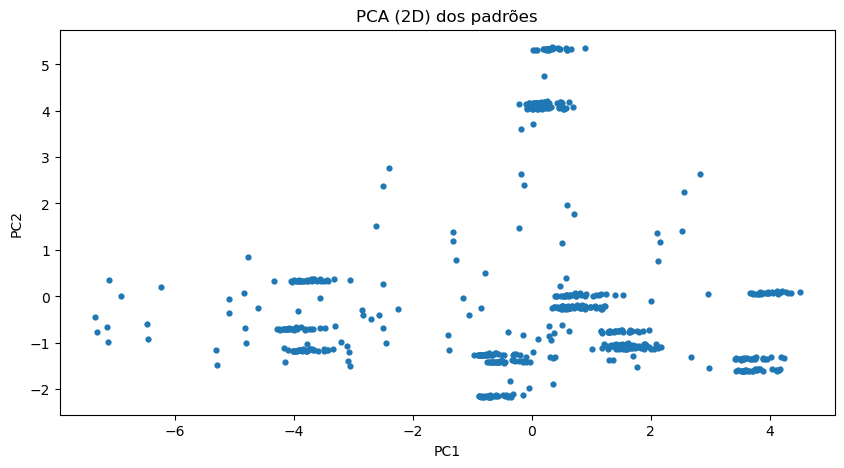

In [24]:
# Seleciona apenas features utilizáveis
usable_cols = [c for c in numeric_cols + categorical_cols if c in df.columns]
if TARGET in usable_cols:
    usable_cols.remove(TARGET)

X_all = df[[c for c in numeric_cols + categorical_cols if c in df.columns]].copy()

unsup_num = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc',  StandardScaler())
])
unsup_cat = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocess_unsuper = ColumnTransformer(
    [('num', unsup_num, [c for c in numeric_cols if c in X_all.columns]),
     ('cat', unsup_cat, [c for c in categorical_cols if c in X_all.columns])],
    remainder='drop'
)

X_proc = preprocess_unsuper.fit_transform(X_all)

# KMeans
try:
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(X_proc)
    df['cluster_k3'] = clusters
    print('Clusters criados: cluster_k3')
except Exception as e:
    print('Falha no KMeans:', e)
    df['cluster_k3'] = np.nan

# PCA para visualização (2D)
try:
    pca = PCA(n_components=2, random_state=42)
    X_dense = X_proc.toarray() if hasattr(X_proc, 'toarray') else X_proc
    X_pca = pca.fit_transform(X_dense)
    plt.figure(figsize=(10, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=12)
    plt.title('PCA (2D) dos padrões')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
except Exception as e:
    print('Falha no PCA/plot:', e)

# 🎯 Etapa 9 — Interpretação do Modelo com *Permutation Importance*

Após o ajuste e validação dos modelos, a próxima etapa consiste em **interpretar a importância das variáveis** (features) no modelo vencedor — no caso, a **Random Forest**.  
Essa etapa é essencial em projetos de Ciência de Dados aplicados à indústria e finanças, pois ajuda a responder a pergunta:  
> “Quais fatores mais influenciam o custo por unidade?”

---

## 🧠 O que é *Permutation Importance*

A **Permutation Importance** (importância por permutação) é um método de interpretação **modelo-agnóstico**, ou seja, pode ser usado com qualquer algoritmo de Machine Learning.  

O raciocínio é simples:
1. Mede-se a **performance do modelo original** (ex.: R² ou RMSE).
2. Em seguida, **embaralha-se uma coluna** do conjunto de teste.
3. Mede-se novamente a performance do modelo.
4. A **queda de desempenho** indica o **quanto aquela coluna era importante** para as previsões.

Quanto maior a queda, **maior a importância da feature**.

---

## ⚙️ Problema prático resolvido

Durante a aplicação do método, surgiu um erro de forma (`ValueError: All arrays must be of the same length`).  
Isso aconteceu porque a lista de nomes das features (`get_feature_names_out()`) não estava **sincronizada com o pipeline de pré-processamento** utilizado dentro do modelo final (`best_rf`).

Em outras palavras:
- O `ColumnTransformer` expandiu as colunas (por exemplo, criou dummies a partir de `site_code` e `m`);
- Mas a função que gerava os nomes (`get_feature_names_out()`) não sabia quais colunas exatas estavam sendo usadas no pipeline;
- Resultado: o vetor de importâncias e a lista de nomes tinham comprimentos diferentes.

---

## ✅ Solução implementada

A correção foi feita garantindo que o vetor de nomes de features seja extraído **diretamente do pipeline treinado**, usando as **mesmas colunas de entrada** (`X_train.columns`):

```python
# Nomes exatos das colunas após one-hot encoding e escala
feat_names = best_rf.named_steps['preprocess'].get_feature_names_out(X_train.columns)

# Calcula importâncias por permutação no conjunto de teste
imp = permutation_importance(best_rf, X_test, y_test,
                             n_repeats=20, random_state=42, scoring='r2')

# Cria DataFrame ordenado de importâncias
fi = (pd.DataFrame({
        'feature': list(feat_names),
        'importance': imp.importances_mean
      })
      .sort_values('importance', ascending=False))

display(fi.head(20))


In [26]:
best_rf.fit(X_train, y_train)

# Get feature names after preprocessing
feat_names = best_rf.named_steps['preprocess'].get_feature_names_out(
    X_train.columns
)

# Calculate permutation importance
imp = permutation_importance(best_rf, X_test, y_test,
                             n_repeats=20, random_state=42, scoring='r2')

# Make sure the arrays have the same length
# This ensures we only use as many feature names as we have importance values
min_length = min(len(feat_names), len(imp.importances_mean))
feat_names = feat_names[:min_length]
importances = imp.importances_mean[:min_length]

# Create DataFrame with matched arrays
fi = pd.DataFrame({
    'feature': list(feat_names),
    'importance': importances
}).sort_values('importance', ascending=False)

display(fi.head(20))

,feature,importance
7,num__fx_effect_ratio_imp_lag1,7.254023e-01
12,cat__m_2,5.511159e-01
3,num__cost_per_unit_imp_lag1,2.758541e-01
6,num__kwh_per_unit_imp_roll3,2.851876e-02
2,num__fx_effect_ratio_imp,1.116607e-02
11,num__fx_effect_ratio_imp_robust,2.088852e-03
14,cat__m_4,5.343642e-04
8,num__fx_effect_ratio_imp_roll3,4.239847e-04
13,cat__m_3,3.374256e-04
0,num__y,-2.664535e-16


## 10. Persistência de artefatos

- Salva *pipelines* treinados (`joblib`)
- Salva bases *train/test* processadas (opcional)


In [25]:
# %%
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Salva melhor pipeline (por RMSE) se disponível
if len(results):
    results_df = pd.DataFrame(results).sort_values('RMSE')
    top_name = results_df.iloc[0]['name']
    best_pipe = fitted[top_name]

# compara com o best_rf (cv) se existir
    try:
        preds_cv = best_rf.predict(X_test)
        rmse_cv  = mean_squared_error(y_test, preds_cv, squared=False)
        if rmse_cv < results_df.iloc[0]['RMSE']:
            best_pipe = best_rf
            top_name  = 'RF_grid'
    except Exception:
        pass

    model_path = MODELS_DIR / f'model_{top_name}_{TARGET}_{timestamp}.joblib'
    joblib.dump(best_pipe, model_path)
    print('Modelo salvo em:', model_path)

# Exporta subconjuntos opcionais
train_out = MODEL_INPUT / f'train_{TARGET}_{timestamp}.parquet'
test_out  = MODEL_INPUT / f'test_{TARGET}_{timestamp}.parquet'
try:
    train_df.to_parquet(train_out, index=False)
    test_df.to_parquet(test_out, index=False)
    print('Train/Test salvos em:', MODEL_INPUT)
except Exception as e:
    print('Falha ao salvar train/test parquet:', e)

Modelo salvo em: /home/rusch/Área de trabalho/Projeto_Whirpool/Data_Science_Projects/eda/models/model_RF_cost_per_unit_imp_20251113_122506.joblib
Train/Test salvos em: /home/rusch/Área de trabalho/Projeto_Whirpool/Data_Science_Projects/eda/data/model_input


In [28]:
pipe.named_steps

{'preprocess': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imp',
                                                   SimpleImputer(strategy='median')),
                                                  ('sc',
                                                   RobustScaler(with_centering=False))]),
                                  ['y', 'kwh_per_unit_imp',
                                   'fx_effect_ratio_imp',
                                   'cost_per_unit_imp_lag1',
                                   'cost_per_unit_imp_roll3',
                                   'kwh_per_unit_imp_lag1',
                                   'kwh_per_unit_imp_roll3',
                                   'fx_effect_ratio_imp_lag1',
                                   'fx_effect_ratio_imp_roll3',
                                   'cost_per_unit_imp_robust',
                                   'kwh_per_unit_imp_robust',
                                   'fx_e

In [29]:
pipe.named_steps['model'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}